<h3>Team Forest<br/>
Biomedial Image Processing Application (BIPA)<br/>
CSC821, Prof. K. Okada<br/>
Spring 2022</h3>

Please note: this code uses Dicom images downloadable at https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=80969742#80969742bcab02c187174a288dbcbf95d26179e8 as well as ones from https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX. Downloading the images requires first installing the NBIA Data Retriever on your local machine which is available in the App Store for Mac and Windows.

This notebook uses Mac/Linux file paths and installations to run. Please make sure that the paths denoted in the code match the paths in your local file system.

<h2>Image I/O</h2>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import SimpleITK as sitk

import sys
import os

<h3>Example of Creating NiFTi Images From DICOM</h3>

In [4]:
dicom_dir = "./LIDC-IDRI/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-30178/3000566.000000-NA-03192/"

print("Reading Dicom directory:", dicom_dir)
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)
reader.SetFileNames(dicom_names)

image = reader.Execute()

size = image.GetSize()
print("Image size:", size[0], size[1], size[2])

print("Writing image:", "LIDC_IDRI_axial_01.nii")

sitk.WriteImage(image, "LIDC_IDRI_axial_01.nii")

if ("SITK_NOSHOW" not in os.environ):
    sitk.Show(image, "Dicom Series")

In [6]:
# example of reading Dicom images from COVID dataset, exporting, and showing outputting 3D image
# axial scan of covid-infected lung showing disease markers

# TO-DO: manually setting path here, need an interface to take input
dicom_dir = "../NBIA_images/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/2.000000-ROUTINE CHEST NON-CON-97100"

print("Reading Dicom directory:", dicom_dir)
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)
reader.SetFileNames(dicom_names)

image = reader.Execute()

size = image.GetSize()
print("Image size:", size[0], size[1], size[2])

print("Writing image:", "MIDRC-RICORD-1A_axial_image.nii")

sitk.WriteImage(image, "MIDRC-RICORD-1A_axial_image.nii")

if ("SITK_NOSHOW" not in os.environ):
    sitk.Show(image, "Dicom Series")

Reading Dicom directory: ../NBIA_images/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/2.000000-ROUTINE CHEST NON-CON-97100
Image size: 512 512 255
Writing image: MIDRC-RICORD-1A_axial_image.nii


In [7]:
# example of 3D image attributes
covid_example = sitk.ReadImage("./MIDRC-RICORD-1A_axial_image.nii")

print(f"origin: {covid_example.GetOrigin()}")
print(f"size: {covid_example.GetSize()}")
print(f"spacing: {covid_example.GetSpacing()}")
print(f"direction: {covid_example.GetDirection()}\n")

print("Dimensions: " + str(covid_example.GetDimension()))
print("Width: " + str(covid_example.GetWidth()))
print("Height: " + str(covid_example.GetHeight()))
print("Depth: " + str(covid_example.GetDepth()))
print("Pixel ID: " + str(covid_example.GetPixelIDValue()))
print("Pixel Type: " + str(covid_example.GetPixelIDTypeAsString()))
print("Components Per Pixel: " + str(covid_example.GetNumberOfComponentsPerPixel()))

origin: (-192.1999969482422, -180.0, -349.25)
size: (512, 512, 255)
spacing: (0.703125, 0.703125, 1.25)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

Dimensions: 3
Width: 512
Height: 512
Depth: 255
Pixel ID: 4
Pixel Type: 32-bit signed integer
Components Per Pixel: 1


In [8]:
# extract modalities of various embedded scans
from ipywidgets import interact, fixed

data_directory = "../NBIA_images/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000361/10-21-2002-NA-CT CHEST WITHOUT CONTRAST-91670/2.000000-ROUTINE CHEST NON-CON-50599"
# Global variable 'selected_series' is updated by the interact function
selected_series = ""
file_reader = sitk.ImageFileReader()


def DICOM_series_dropdown_callback(series_to_load, series_dictionary):
    global selected_series
    # Print some information about the series from the meta-data dictionary
    # DICOM standard part 6, Data Dictionary: http://medical.nema.org/medical/dicom/current/output/pdf/part06.pdf
    file_reader.SetFileName(series_dictionary[series_to_load][0])
    file_reader.ReadImageInformation()
    tags_to_print = {
        "0010|0010": "Patient name: ",
        "0008|0060": "Modality: ",
        "0008|0021": "Series date: ",
        "0008|0080": "Institution name: ",
        "0008|1050": "Performing physician's name: ",
    }
    for tag in tags_to_print:
        try:
            print(tags_to_print[tag] + file_reader.GetMetaData(tag))
        except:  # Ignore if the tag isn't in the dictionary
            pass
    selected_series = series_to_load


# Directory contains multiple DICOM studies/series, store
# in dictionary with key being the series ID
reader = sitk.ImageSeriesReader()
series_file_names = {}
series_IDs = reader.GetGDCMSeriesIDs(data_directory)
# Check that we have at least one series
if series_IDs:
    for series in series_IDs:
        series_file_names[series] = reader.GetGDCMSeriesFileNames(
            data_directory, series
        )

    interact(
        DICOM_series_dropdown_callback,
        series_to_load=list(series_IDs),
        series_dictionary=fixed(series_file_names),
    )
else:
    print("Data directory does not contain any DICOM series.")

interactive(children=(Dropdown(description='series_to_load', options=('1.2.826.0.1.3680043.10.474.419639.44260…

<h2>Registration</h2>

<h3>Intensity Based Registration</h3>

In [1]:
# utility functions
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [4]:
# load fixed and moving images to register
fixed = sitk.ReadImage("LIDC_IDRI_axial_01.nii", sitk.sitkFloat32)
moving = sitk.ReadImage("2.000000-ROUTINE CHEST NON-CON-50599.nii", sitk.sitkFloat32)

In [15]:
def command_iteration(method):
    print(f"{method.GetOptimizerIteration():3} = {method.GetMetricValue():10.5f} : {method.GetOptimizerPosition()}")

R = sitk.ImageRegistrationMethod()
R.SetMetricAsMeanSquares()
R.SetOptimizerAsRegularStepGradientDescent(4.0, .01, 200)
R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))
R.SetInterpolator(sitk.sitkLinear)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

sitk.WriteTransform(outTx, "registered_intensity_3D.tfm")

if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
    sitk.Show(cimg, "Intensity-Based Composition")

  0 = 524504.16406 : (-3.255615129775106, 2.323851908040856, -0.02612348128207581)
  1 = 489938.05798 : (-6.542470298055147, 4.603314059596745, -0.05133067023662149)
  2 = 452205.97909 : (-9.79413712880736, 6.932803701419525, -0.06319786983137111)
  3 = 416939.07293 : (-12.76161411445948, 9.61496881791417, -0.05479385386992799)
  4 = 402008.21773 : (-10.985549997729429, 8.695667364927838, -0.032860048884778496)
  5 = 399418.20032 : (-11.958846060734587, 8.924893475842117, -0.020605914326384638)
  6 = 392508.13118 : (-11.459455484396903, 8.903660965110012, -0.00802685422126979)
  7 = 391997.58840 : (-11.709047851419925, 8.904601948379502, 0.0062126989434687484)
  8 = 393637.68318 : (-11.584470001611326, 8.907717159856604, 0.015993025856166077)
  9 = 392361.30888 : (-11.641178011422403, 8.904091815816395, 0.04201817722665635)
 10 = 392964.07601 : (-11.610650811742476, 8.906043910869883, 0.04840894436402031)
 11 = 392639.32004 : (-11.588279340827354, 8.90756112767456, 0.07017538280170318)

In [5]:
# resampler = sitk.ResampleImageFilter()
# resampler.SetReferenceImage(fixed)
# resampler.SetInterpolator(sitk.sitkLinear)
# resampler.SetDefaultPixelValue(100)
# resampler.SetTransform(outTx)

# out = resampler.Execute(moving)

# interact(
#     display_images_with_alpha,
#     image_z=(0, fixed.GetSize()[2] - 1),
#     alpha=(0.0, 1.0, 0.05),
#     fixed=fixed,
#     moving=out,
# );

<h3>Similarity 3D Transformation</h3>

In [6]:
# load fixed and moving images to register
fixed = sitk.ReadImage("LIDC_IDRI_axial_01.nii", sitk.sitkFloat32)
moving = sitk.ReadImage("2.000000-ROUTINE CHEST NON-CON-50599.nii", sitk.sitkFloat32)

In [7]:
R = sitk.ImageRegistrationMethod()

R.SetMetricAsCorrelation()

R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                           minStep=1e-4,
                                           numberOfIterations=500,
                                           gradientMagnitudeTolerance=1e-8)
R.SetOptimizerScalesFromIndexShift()

tx = sitk.CenteredTransformInitializer(fixed, moving, sitk.Similarity3DTransform())

In [8]:
def command_iteration(method):
    if (method.GetOptimizerIteration() == 0):
        print("Estimated Scales: ", method.GetOptimizerScales())
    print(f"{method.GetOptimizerIteration():3} = {method.GetMetricValue():7.5f} : {method.GetOptimizerPosition()}")

R.SetInitialTransform(tx)

R.SetInterpolator(sitk.sitkLinear)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

Estimated Scales:  (77766.81562058833, 77150.3963728492, 135162.23070764923, 2.0227160493790284, 2.0227160493905236, 0.6399999999987221, 152999.353016389)
  0 = -0.74770 : (-0.00019472214608236242, 0.0007758282028360315, -0.00017238707743845168, -10.664098433911642, 9.296493923421538, 5.276598119545042, 1.0043824363873257)
  1 = -0.74758 : (-0.00034569158220680487, 0.0010706838821493009, -0.00012854325238347166, -11.532498289729325, 8.808882351632258, 5.186512325603588, 1.0035172272329715)
  2 = -0.75363 : (-0.0007576793537345701, 0.0017871418883573138, -0.0003395423541208101, -11.904358123481611, 8.470578119196285, 4.32209737862947, 0.9961416233972097)
  3 = -0.74785 : (-0.0007475255563833205, 0.0015940725058443848, -0.00036630216528021935, -11.64018557510421, 8.89017219030324, 4.257858774437339, 1.0013309901035186)
  4 = -0.76019 : (-0.000265957832027513, 0.0004431785000307785, -0.0004495765795756355, -11.349610186086563, 8.73972443389697, 3.879848160897685, 1.0070875807631907)
  5 =

 48 = -0.75778 : (-0.0004868686032902062, 0.0011664687402186654, -0.0012532667203823751, -11.615568008765546, 8.802382254251158, 0.759085931945206, 1.0026428160810406)
 49 = -0.75767 : (-0.0004832271077744338, 0.001175455290332879, -0.0012688524307894944, -11.561271752368771, 8.797630329572428, 0.7284986340562106, 1.0026026506955332)
 50 = -0.75778 : (-0.0004852657935296395, 0.0011699977355536166, -0.0012717438088894204, -11.588809725798589, 8.799957108130165, 0.7139106931176491, 1.0026234085890045)
 51 = -0.75773 : (-0.0004860449300397669, 0.0011695621004522224, -0.00128311219039318, -11.589643710102413, 8.799945191147444, 0.6826718341784093, 1.00262384702503)
 52 = -0.75773 : (-0.00048767053934405336, 0.0011703911648296011, -0.001294748740201535, -11.588723837390399, 8.800044039898058, 0.6514355410561791, 1.002624224128653)
 53 = -0.75772 : (-0.0004895379383649946, 0.001170492968011019, -0.0013066425234779596, -11.590065324137871, 8.7999242124903, 0.6202145869813884, 1.00262545657944

 97 = -0.75775 : (-0.0004989197763180445, 0.0011965096162494487, -0.0016300002677508698, -11.599177799589414, 8.797477721463704, -0.1587409823130053, 1.002635698000005)
 98 = -0.75773 : (-0.0004983998717382307, 0.0011984103781870156, -0.0016327060672194271, -11.592362650260778, 8.796753308444657, -0.16249118801537948, 1.002629864668669)
 99 = -0.75774 : (-0.0004983137106766896, 0.0011984156712297918, -0.001637108376150532, -11.592658962636847, 8.796768419581214, -0.17029804713476024, 1.0026299994798002)
100 = -0.75774 : (-0.000498004463313925, 0.0011988384940487932, -0.001641606487124563, -11.592447003059759, 8.79678740868588, -0.17810764294786616, 1.002629912287873)
101 = -0.75775 : (-0.0004974324775871359, 0.0011993982721036826, -0.001646108816575869, -11.592912570091235, 8.796881294494197, -0.18590568790455297, 1.002630413775688)
102 = -0.75775 : (-0.0004969160061605184, 0.001200038374744689, -0.0016507684801045487, -11.59244388431882, 8.796802064044178, -0.19370370833887857, 1.0026

146 = -0.75779 : (-0.000503764406265655, 0.0011992235628643527, -0.0017849870705520599, -11.591582890538003, 8.795211899460663, -0.3639597210047606, 1.0026314992831915)
147 = -0.75780 : (-0.000503927610898653, 0.001198761231488521, -0.0017858832969957022, -11.59329318940628, 8.795374879607984, -0.36488870228202025, 1.0026329588849636)
148 = -0.75780 : (-0.0005040083124650311, 0.0011987947345422894, -0.00178809751665127, -11.593376749049217, 8.795370000700007, -0.3668400278799088, 1.0026330904080027)
149 = -0.75780 : (-0.0005041229613892657, 0.0011987875933357726, -0.0017903577051950619, -11.59330300884725, 8.795323873407257, -0.3687912099407149, 1.0026330962143601)
150 = -0.75780 : (-0.0005042049467715037, 0.001198765526570132, -0.0017926329898154932, -11.593427340271846, 8.795332118404742, -0.37074035082995843, 1.0026332957057784)
151 = -0.75780 : (-0.0005042816382366154, 0.00119869024883515, -0.001794978325794345, -11.593271876088345, 8.795277296381025, -0.3726865010378915, 1.0026331

195 = -0.75787 : (-0.0005053315367481499, 0.0011984388826697132, -0.0018688771056849386, -11.593857805596373, 8.794798092957455, -0.4161642018771175, 1.002635508069786)
196 = -0.75787 : (-0.0005053475490047617, 0.0011985002308791141, -0.0018701464802843987, -11.593926533273356, 8.794795183035292, -0.41664760662322325, 1.0026355973002146)
197 = -0.75787 : (-0.0005053246954933417, 0.0011985865793658747, -0.0018714593409622751, -11.593882828853644, 8.794789595152295, -0.41713388879638097, 1.0026355883590712)
198 = -0.75787 : (-0.0005053424334673574, 0.0011986013647587574, -0.001872757162176601, -11.593966312928664, 8.794780064453313, -0.41761487882506676, 1.0026356713329256)
199 = -0.75787 : (-0.0005052941562287048, 0.0011986927559517345, -0.0018741226712273113, -11.593899763501563, 8.794786523379305, -0.4180985528205414, 1.0026356680571598)
200 = -0.75787 : (-0.0005053277610317266, 0.0011987339108821804, -0.0018754493809777734, -11.594030415950808, 8.794759683182766, -0.4185682559775823,

244 = -0.75786 : (-0.0005054097227851309, 0.0011997338001041343, -0.0019130349586925968, -11.594362840389778, 8.79458330279271, -0.4285965426921715, 1.0026365813133231)
245 = -0.75786 : (-0.0005054323801988444, 0.0011997632129254914, -0.0019136612561737498, -11.59439978492254, 8.794578261569857, -0.4287127720860755, 1.002636628678795)
246 = -0.75786 : (-0.0005054309179797816, 0.0011997873144685102, -0.0019143160130683265, -11.594372792192537, 8.794577109298979, -0.42883180783032826, 1.002636608238822)
247 = -0.75786 : (-0.000505430136571133, 0.00119978601618097, -0.0019149424322904094, -11.594417048916096, 8.794575901406986, -0.42894555963687897, 1.002636646943664)
248 = -0.75786 : (-0.0005054152277325248, 0.001199803934005417, -0.001915599407640129, -11.594379965254035, 8.794573366414395, -0.42906182574380375, 1.0026366195772227)
249 = -0.75786 : (-0.0005054112443386666, 0.0011997965954057414, -0.0019162073412963524, -11.59443658302822, 8.794573538884064, -0.42916996490505316, 1.00263

In [9]:
print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

sitk.WriteTransform(outTx, "registered_similarity_3D.tfm")

-------
itk::simple::Transform
 Similarity3DTransform (0x7fe7e7015b70)
   RTTI typeinfo:   itk::Similarity3DTransform<double>
   Reference Count: 3
   Modified Time: 3586
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.00263 0.003863 0.00240839 
     -0.00386543 1.00263 0.0010088 
     -0.00240448 -0.00101807 1.00263 
   Offset: [-11.2282, 9.01899, 0.0637135]
   Center: [14.8988, 2.93955, -173.061]
   Translation: [-11.5945, 8.79454, -0.430839]
   Inverse: 
     0.99736 -0.00384513 -0.00239185 
     0.00384271 0.997362 -0.00101273 
     0.00239574 0.0010035 0.997367 
   Singular: 0
   Versor: [ -0.000505387, 0.00120006, -0.00192703, 0.999997 ]
   Scale = 1.00264

Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Step too small after 271 iterations. Current step (6.10352e-05) is less than minimum step (0.0001).
 Iteration: 272
 Metric value: -0.7578561510144566


In [10]:
if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(1)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)

    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
    sitk.Show(cimg, "Similarity-Based Composition")

<h3>Same using coronal image</h3>

In [11]:
# load fixed and moving images to register
fixed = sitk.ReadImage("coronal_lung_window.nii", sitk.sitkFloat32)
moving = sitk.ReadImage("MIDRC-RICORD-1A_coronal_image.nii", sitk.sitkFloat32)

In [12]:
R = sitk.ImageRegistrationMethod()

R.SetMetricAsCorrelation()

R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                           minStep=1e-4,
                                           numberOfIterations=500,
                                           gradientMagnitudeTolerance=1e-8)
R.SetOptimizerScalesFromIndexShift()

tx = sitk.CenteredTransformInitializer(fixed, moving, sitk.Similarity3DTransform())

In [13]:
def command_iteration(method):
    if (method.GetOptimizerIteration() == 0):
        print("Estimated Scales: ", method.GetOptimizerScales())
    print(f"{method.GetOptimizerIteration():3} = {method.GetMetricValue():7.5f} : {method.GetOptimizerPosition()}")

R.SetInitialTransform(tx)

R.SetInterpolator(sitk.sitkLinear)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

Estimated Scales:  (159549.91317290755, 146227.91658701916, 153719.91236667268, 0.08212831833655813, 2.0227160493768808, 2.0227160493768808, 165485.19251481773)
  0 = -0.00046 : (2.6465332948649457e-05, -1.6777484869884517e-05, 3.0785497956854134e-05, -434.84669792219734, -281.2048273987524, -191.6793442971687, 0.9997742631165594)
  1 = -0.00084 : (5.4100741809217027e-05, -3.337495428734658e-05, 5.850657974652498e-05, -432.8467215261659, -281.19623041646815, -191.67482314110268, 0.999531096832105)
  2 = -0.00137 : (8.228873395705646e-05, -4.938601812879217e-05, 8.2527995223093e-05, -430.8467522647948, -281.1881268013181, -191.6672591972593, 0.9992756870575225)
  3 = -0.00203 : (0.00011131833845311484, -6.518333984631151e-05, 0.00010421363529379774, -428.8467967565722, -281.1806819340603, -191.65619308874668, 0.9990035221657736)
  4 = -0.00279 : (0.0001418278118030588, -8.139288479909817e-05, 0.0001250826820743031, -426.8468665496694, -281.173769527385, -191.6409848440496, 0.99870531303

 48 = -0.00719 : (0.007824170252391812, -0.00672816839640421, 0.008631154724630146, -418.8946669292604, -283.04706480003296, -186.8109223805491, 0.929751927576905)
 49 = -0.00716 : (0.007916064452222656, -0.006801307650263967, 0.00872376670386251, -418.9326068573223, -283.0765231627235, -186.77093841655, 0.9292938344382581)
 50 = -0.00714 : (0.008007849698828402, -0.006874455660799389, 0.008816016880473423, -418.97067832421, -283.10600751697, -186.73109882597635, 0.9288420281421266)
 51 = -0.00712 : (0.008101459834870805, -0.006949113039805203, 0.008909991319501109, -419.00756890788, -283.13605832430574, -186.69057742248938, 0.9283870714356066)
 52 = -0.00710 : (0.008194066186558135, -0.007023055440631401, 0.009002652317328903, -419.04520790711877, -283.165891610372, -186.6505868940372, 0.9279422373704809)
 53 = -0.00708 : (0.008287290379549402, -0.007097594033415727, 0.009095489380661478, -419.08247529563874, -283.1959388995211, -186.61040897525018, 0.9275000501744096)
 54 = -0.00705 

 98 = -0.00622 : (0.012859428430347585, -0.010885509506990472, 0.013402781725345701, -420.5274827125513, -284.71688790872435, -184.74488389683316, 0.9111547191968283)
 99 = -0.00621 : (0.012968358778966016, -0.010979251994105479, 0.013501244707651367, -420.55439222143906, -284.75424965436457, -184.7026225265784, 0.9108658799034941)
100 = -0.00619 : (0.013077016875590115, -0.01107292540518245, 0.01359933992247711, -420.5816338438945, -284.7915849161993, -184.66055091586875, 0.9105813995261248)
101 = -0.00617 : (0.013185936742789794, -0.01116699144114494, 0.013697536667131388, -420.6086115387003, -284.8290918095618, -184.61846188958702, 0.9102997554366689)
102 = -0.00616 : (0.013297097458305056, -0.01126316163679348, 0.013797580319965686, -420.6330339968406, -284.86745062906937, -184.5755878004133, 0.9100160943006874)
103 = -0.00615 : (0.013407804381295785, -0.011359104139110301, 0.013897081972478924, -420.6579897555564, -284.9057455406342, -184.53296437137942, 0.9097374473439765)
104 = 

148 = -0.00560 : (0.018476747830307297, -0.015907754741869645, 0.01831631155929959, -421.5496465614443, -286.780508915565, -182.6421300064528, 0.900174089205191)
149 = -0.00559 : (0.018589262300171067, -0.016011870896954467, 0.01841182457005335, -421.5644671156138, -286.8251063970149, -182.60092914361726, 0.9000188048469505)
150 = -0.00558 : (0.018701545410483814, -0.01611588396059582, 0.018507040620670635, -421.5793784904099, -286.8697607806026, -182.5598227762653, 0.8998658346307938)
151 = -0.00557 : (0.018813424161660257, -0.01621964130444198, 0.018601813371618505, -421.5947790947465, -286.91439226118985, -182.51887219022638, 0.8997153360678192)
152 = -0.00557 : (0.018925124819577803, -0.016323360011477158, 0.018696332887914665, -421.61018942243226, -286.95908757233605, -182.477994933291, 0.8995669119189926)
153 = -0.00556 : (0.01903681737269583, -0.016427196699277537, 0.01879072893080103, -421.6252487765277, -287.0039119778286, -182.43712822025122, 0.8994202998380555)
154 = -0.0055

198 = -0.00524 : (0.02390455568869253, -0.02104991899184879, 0.022811008185637402, -422.17163426897383, -289.1043910853899, -180.65034997415685, 0.8945035463489697)
199 = -0.00523 : (0.02400845421678884, -0.021150134312151105, 0.022895118288523447, -422.1813570156705, -289.1526408812653, -180.61183300136528, 0.894423665645154)
200 = -0.00522 : (0.024112030682194665, -0.02125007559804576, 0.022978949058502115, -422.1913859869012, -289.2009004567878, -180.57340689374644, 0.8943448435942459)
201 = -0.00522 : (0.024215418871351715, -0.021349877612953906, 0.023062545897574026, -422.20123929765754, -289.24922782879526, -180.5350205603027, 0.8942669784881426)
202 = -0.00521 : (0.024318511415918908, -0.021449430852213333, 0.02314587681860449, -422.2113286020759, -289.29756892983136, -180.49671288651314, 0.8941900910668282)
203 = -0.00521 : (0.024421335443641685, -0.021548761958762104, 0.023228947565459297, -422.2214895960254, -289.34594865465226, -180.45847297118257, 0.8941141297320513)
204 = 

248 = -0.00498 : (0.028817817420243075, -0.025789633646618116, 0.026741187861944158, -422.6073165286824, -291.565229089928, -178.77497496553673, 0.8914494442228313)
249 = -0.00498 : (0.028910353906779825, -0.02587760120864706, 0.02681423804842887, -422.61492179017955, -291.61505780044155, -178.73802336539632, 0.8914034894006798)
250 = -0.00497 : (0.02900267289792543, -0.025965242157486388, 0.02688707765328307, -422.62243135401286, -291.66490167023323, -178.70107263072933, 0.8913579424973954)
251 = -0.00497 : (0.02909479905422494, -0.02605257221300737, 0.026959722037709934, -422.6297688433935, -291.71476357005037, -178.6641116457885, 0.8913128485148327)
252 = -0.00496 : (0.029186688897291056, -0.02613954668820388, 0.027032110107946018, -422.63726662493616, -291.7646065926182, -178.62715736059258, 0.8912681875481512)
253 = -0.00496 : (0.02927842269037772, -0.026226239745520533, 0.02710434307076905, -422.6444166496708, -291.8144798918258, -178.59017500762528, 0.8912239529843579)
254 = -0.

298 = -0.00485 : (0.033216506498220805, -0.029719968891037122, 0.0301520320002981, -422.93269605954, -294.0459159195747, -176.90302681876338, 0.8895941574488879)
299 = -0.00485 : (0.03330043333279625, -0.029787184678514614, 0.030215696455726047, -422.93795884982615, -294.0949966369729, -176.86469181292563, 0.8895640679401875)
300 = -0.00485 : (0.03338416178410826, -0.029853835420755398, 0.030279154580712883, -422.94367449884584, -294.14401373401654, -176.82634024763246, 0.8895341612455899)
301 = -0.00485 : (0.03346780762082832, -0.029920006174434723, 0.030342483249064252, -422.9489420307564, -294.1930261383149, -176.7879185776273, 0.8895044307884883)
302 = -0.00485 : (0.03355135237260194, -0.029985673781758267, 0.030405656259509528, -422.95391187380744, -294.2420212413715, -176.74943522597536, 0.8894749062701478)
303 = -0.00485 : (0.033634713541261484, -0.03005076942949777, 0.030468639476372777, -422.9592429325149, -294.29096052420465, -176.71092919065504, 0.889445571488041)
304 = -0.0

348 = -0.00487 : (0.037255458536114075, -0.032376347176221905, 0.03315481266865403, -423.1544813764802, -296.4541017603161, -174.92470617485887, 0.8882588949070673)
349 = -0.00487 : (0.03733300919568129, -0.03241355031257546, 0.033211356388754464, -423.1578764795923, -296.50114900037386, -174.88370328029063, 0.8882346028609143)
350 = -0.00488 : (0.03741044987023052, -0.032450098853786066, 0.03326777140999074, -423.1610356885311, -296.54814682812463, -174.84262493083295, 0.8882103737415891)
351 = -0.00488 : (0.03748775452007164, -0.03248597855522004, 0.03332404073716766, -423.16426263911814, -296.5950847624139, -174.80148341078245, 0.8881862329503012)
352 = -0.00488 : (0.03756493441497056, -0.032521192691645454, 0.033380168382770144, -423.1673105329846, -296.64197357202494, -174.76027227431743, 0.8881621744484324)
353 = -0.00488 : (0.037641971232095034, -0.03255573423511831, 0.033436164816214066, -423.1704564051164, -296.68880269991854, -174.7190006799691, 0.888138168209601)
354 = -0.00

398 = -0.00496 : (0.040963510381893976, -0.03341724700964328, 0.035802576190613875, -423.2798073476353, -298.72167399441963, -172.7798033740267, 0.8871177526587429)
399 = -0.00496 : (0.04103387245360635, -0.03342125862254759, 0.035851473660947354, -423.28177259412803, -298.76480209686133, -172.7346112883706, 0.8870963718838558)
400 = -0.00497 : (0.04110407725577813, -0.03342463847667082, 0.035900199230441576, -423.2835964027945, -298.80782860677283, -172.68931654955978, 0.8870750372052533)
401 = -0.00497 : (0.04117411936855588, -0.033427387546540885, 0.03594874531110859, -423.2854338061601, -298.85074866272805, -172.64392147137895, 0.8870537641586862)
402 = -0.00497 : (0.04124399990710135, -0.033429512778646496, 0.035997120426254185, -423.28720239558226, -298.8935634441836, -172.59842436015452, 0.8870325417753403)
403 = -0.00498 : (0.04131371325718576, -0.033431012918292057, 0.036045318584586615, -423.2890774682673, -298.9362681764185, -172.55282819067432, 0.8870113880837667)
404 = -0.

448 = -0.00526 : (0.044269382694797826, -0.03292181366846587, 0.038035428051871156, -423.375067431537, -300.7414713107051, -170.39957345823993, 0.8861209732747475)
449 = -0.00527 : (0.0443308315329036, -0.03289957896773888, 0.03807591475144099, -423.3773681349676, -300.77909357414006, -170.34971868886973, 0.8861025168763151)
450 = -0.00527 : (0.04439209001360326, -0.03287696756369712, 0.03811625562608666, -423.3797678803648, -300.8166200768102, -170.2997964606939, 0.8860841113445634)
451 = -0.00528 : (0.04445316294025254, -0.03285398361832777, 0.03815645211527046, -423.3821480858225, -300.8540539243217, -170.24980378321933, 0.8860657608497723)
452 = -0.00529 : (0.04451404636979439, -0.03283063680518191, 0.03819651028573491, -423.3845635397697, -300.891396361252, -170.19974447662057, 0.8860474663850846)
453 = -0.00530 : (0.04457473932277945, -0.03280693437657291, 0.038236432787613905, -423.3870879898835, -300.9286463151928, -170.14962168395024, 0.8860292149993418)
454 = -0.00531 : (0.04

499 = -0.00580 : (0.04717413976406051, -0.03144311743260989, 0.03996217030780487, -423.5481648101864, -302.5740962327166, -167.79806302783138, 0.8852370760326183)


In [14]:
print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

sitk.WriteTransform(outTx, "similarity_coronal_3D.tfm")

-------
itk::simple::Transform
 Similarity3DTransform (0x7fe7f5f22e20)
   RTTI typeinfo:   itk::Similarity3DTransform<double>
   Reference Count: 3
   Modified Time: 7750
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.880659 -0.0732077 -0.0521975 
     0.0679554 0.87847 -0.0855441 
     0.0588728 0.0810948 0.879547 
   Offset: [-370.228, -285.592, -204.708]
   Center: [268.798, 280.383, 13.7158]
   Translation: [-423.548, -302.574, -167.798]
   Inverse: 
     1.1238 0.0867172 0.0751269 
     -0.0934196 1.12101 0.103484 
     -0.0666086 -0.109162 1.12238 
   Singular: 0
   Versor: [ 0.0471741, -0.0314431, 0.0399622, 0.997592 ]
   Scale = 0.885237

Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (500) exceeded.
 Iteration: 500
 Metric value: -0.0058029883516913135


In [15]:
if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(1)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)

    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
    sitk.Show(cimg, "ImageRegistration2 Composition")

<h3>3D Rigid Registration</h3>

In [16]:
OUTPUT_DIR = "./"

# Actually read the data based on the user's selection.
fixed_image = sitk.ReadImage("LIDC_IDRI_axial_01.nii", sitk.sitkFloat32)
moving_image = sitk.ReadImage("2.000000-ROUTINE CHEST NON-CON-50599.nii", sitk.sitkFloat32)

# Save images to file and view overlap using external viewer.
sitk.WriteImage(fixed_image, os.path.join(OUTPUT_DIR, "fixedImage.mha"))
sitk.WriteImage(moving_image, os.path.join(OUTPUT_DIR, "preAlignment.mha"))

MetaImageIO (0x7fe826385200): Unsupported or empty metaData item ITK_FileNotes of type NSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEEfound, won't be written to image file

MetaImageIO (0x7fe826385200): Unsupported or empty metaData item aux_file of type NSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEEfound, won't be written to image file

MetaImageIO (0x7fe826385200): Unsupported or empty metaData item descrip of type NSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEEfound, won't be written to image file

MetaImageIO (0x7fe826385200): Unsupported or empty metaData item intent_name of type NSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEEfound, won't be written to image file

MetaImageIO (0x7fe826385200): Unsupported or empty metaData item ITK_FileNotes of type NSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEEfound, won't be written to image file

MetaImageIO (0x7fe826385200): Unsupported or empty metaData item aux_file

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1, 2, figsize=(10, 8))

    # Draw the fixed image in the first subplot.
    plt.subplot(1, 2, 1)
    plt.imshow(fixed_npa[fixed_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("fixed image")
    plt.axis("off")

    # Draw the moving image in the second subplot.
    plt.subplot(1, 2, 2)
    plt.imshow(moving_npa[moving_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("moving image")
    plt.axis("off")

    plt.show()


# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha) * fixed[:, :, image_z] + alpha * moving[:, :, image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()


# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.show()


# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values)) 

In [19]:
# Actually read the data based on the user's selection.
fixed_image = sitk.ReadImage("LIDC_IDRI_axial_01.nii", sitk.sitkFloat32)
moving_image = sitk.ReadImage("2.000000-ROUTINE CHEST NON-CON-50599.nii", sitk.sitkFloat32)

In [ ]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    initial_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)

interact(
    display_images_with_alpha,
    image_z=(0, fixed_image.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed_image,
    moving=moving_resampled,
);

In [ ]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0,
    numberOfIterations=100,
    convergenceMinimumValue=1e-6,
    convergenceWindowSize=10,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent, update_multires_iterations
)
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: plot_values(registration_method)
)

final_transform = registration_method.Execute(
    sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
)

In [ ]:
print(f"Final metric value: {registration_method.GetMetricValue()}")
print(
    f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
)

<h3>Output Resampled Moving Image and Fixed Image With Sliders to Compare</h3>

In [ ]:
moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    final_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)

interact(
    display_images_with_alpha,
    image_z=(0, fixed_image.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(fixed_image),
    moving=fixed(moving_resampled),
);

In [ ]:
sitk.WriteTransform(
    final_transform, os.path.join(OUTPUT_DIR, "registered_rigid.tfm")
)

<h3>Gaussian Interpolator Using Bins</h3>

In [2]:
def command_iteration(method):
    print(f"{method.GetOptimizerIteration():3} = {method.GetMetricValue():10.5f} : {method.GetOptimizerPosition()}")

In [3]:
fixed = sitk.ReadImage("LIDC_IDRI_axial_01.nii", sitk.sitkFloat32)
moving = sitk.ReadImage("2.000000-ROUTINE CHEST NON-CON-50599.nii", sitk.sitkFloat32)

In [4]:
numberOfBins = 24
samplingPercentage = 0.10

# numberOfBins = 10
# samplingPercentage = .2

R = sitk.ImageRegistrationMethod()
R.SetMetricAsMattesMutualInformation(numberOfBins)
R.SetMetricSamplingPercentage(samplingPercentage, sitk.sitkWallClock)
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetOptimizerAsRegularStepGradientDescent(1.0, .001, 200)
R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))
R.SetInterpolator(sitk.sitkGaussian)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

# sitk.WriteTransform(outTx, "registration_gaussian_3D.tfm")
sitk.WriteTransform(outTx, "registration_nearestNeighbor_3D.tfm")

if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
    sitk.Show(cimg, "Gaussian Axial 3D Registration")

  0 =   -0.42801 : (-0.7877859634453688, 0.6126439828738339, -0.06372304172697238)
  1 =   -0.44041 : (-1.5787878836233937, 1.2211339960934149, -0.1274087236869846)
  2 =   -0.45309 : (-2.3769110981269175, 1.8202089533208456, -0.19150654029187814)
  3 =   -0.46591 : (-3.186673189880355, 2.4035087179516217, -0.2551205272819973)
  4 =   -0.47908 : (-3.9995512621352503, 2.982705530767407, -0.3164417444193116)
  5 =   -0.49262 : (-4.811705556035336, 3.56319386251768, -0.3750821707601803)
  6 =   -0.50670 : (-5.6270253055052635, 4.139681136034156, -0.4290833707268051)
  7 =   -0.52114 : (-6.441497446957565, 4.717793782516276, -0.47828600048925424)
  8 =   -0.53635 : (-7.261746807443791, 5.288319943074132, -0.5194063937394224)
  9 =   -0.55238 : (-8.066825203931357, 5.8805012561295085, -0.5536126501411385)
 10 =   -0.56937 : (-8.873295515585792, 6.471127033475585, -0.5813043014884652)
 11 =   -0.58779 : (-9.667802071203669, 7.078015728913873, -0.6024098559571532)
 12 =   -0.60834 : (-10.4397

<h3>Landmark Based Registration</h3>

In [5]:
import SimpleITK as sitk

%run setup_for_testing

import os
import numpy as np

from ipywidgets import interact, fixed
%run update_path_to_download_script

%matplotlib notebook
import gui

# This is the registration configuration which we use in all cases. The only parameter that we vary 
# is the initial_transform. 
def multires_registration(fixed_image, moving_image, initial_transform):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, estimateLearningRate=registration_method.Once)
    registration_method.SetOptimizerScalesFromPhysicalShift() 
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    final_transform = registration_method.Execute(fixed_image, moving_image)
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    return (final_transform, registration_method.GetMetricValue())

In [6]:
fixed_image = sitk.ReadImage("LIDC_IDRI_axial_01.nii", sitk.sitkFloat32)
moving_image = sitk.ReadImage("2.000000-ROUTINE CHEST NON-CON-50599.nii", sitk.sitkFloat32)

clean_window_level = [1727,-320]
covid_window_level = [1727,-320]

<IPython.core.display.Javascript object>


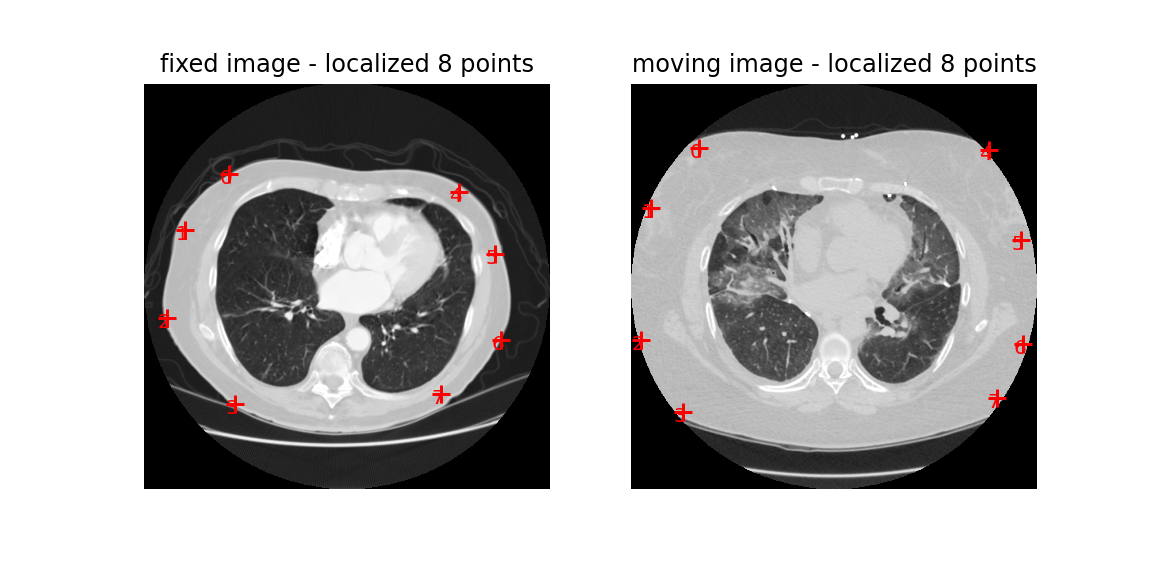

In [7]:
point_acquisition_interface = gui.RegistrationPointDataAquisition(fixed_image, moving_image, figure_size=(8,4), fixed_window_level=clean_window_level, moving_window_level=covid_window_level);

In [11]:
fixed_image_points, moving_image_points = point_acquisition_interface.get_points()
fixed_image_points_flat = [c for p in fixed_image_points for c in p]        
moving_image_points_flat = [c for p in moving_image_points for c in p]
initial_transformation = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), 
                                                                fixed_image_points_flat, 
                                                                moving_image_points_flat)

final_transform,_ = multires_registration(fixed_image, moving_image, initial_transformation)

Final metric value: -0.6551202394990607
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 18.


In [14]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
# sitk.WriteImage(moving_resampled, os.path.join(OUTPUT_DIR, 'RIRE_training_001_mr_T1_resampled.mha'))
sitk.WriteTransform(final_transform, './covid_axial_landmark_based.tfm')

if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    # resampler.SetTransform(outTx)

    out = resampler.Execute(moving_image)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed_image), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(moving_resampled), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
    sitk.Show(cimg, "Landmark Composition")

<h2>Segmentation</h2>

In [15]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

import SimpleITK as sitk

# Download data to work on
%run update_path_to_download_script
# from downloaddata import fetch_data as fdata
from myshow import myshow, myshow3d
  
# Read the image
dicom_dir = "../NBIA_images/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/2.000000-ROUTINE CHEST NON-CON-97100"

print("Reading Dicom directory:", dicom_dir)
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)

reader.SetFileNames(dicom_names)
image = reader.Execute()

seg = image > 200
myshow(sitk.LabelOverlay(image, seg), "Basic Thresholding")

Reading Dicom directory: ../NBIA_images/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/2.000000-ROUTINE CHEST NON-CON-97100


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

In [16]:
# To visualize the labels image in RGB with needs a image with 0-255 range
image_rgb = sitk.Cast(sitk.RescaleIntensity(image), sitk.sitkUInt8)

<h3>Using Binary</h3>

In [17]:
seg = sitk.BinaryThreshold(image, lowerThreshold=100, upperThreshold=400, insideValue=1, outsideValue=0)
myshow(sitk.LabelOverlay(image_rgb, seg), "Binary Thresholding")

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

<h3>Using Otsu</h3>

In [18]:
otsu_filter = sitk.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(0)
otsu_filter.SetOutsideValue(1)
seg = otsu_filter.Execute(image_rgb)
myshow(sitk.LabelOverlay(image_rgb, seg), "Otsu Thresholding")

print(otsu_filter.GetThreshold() )

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

1.0


In [19]:
# Using an external viewer (ITK-SNAP or 3D Slicer) we identified a visually appealing window-level setting
T1_WINDOW_LEVEL = (1050, 500)

In [20]:
# image = sitk.ReadImage("NBIA_images/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/2.000000-ROUTINE CHEST NON-CON-97100")
# Rescale the intensities and map them to [0,255], these are the default values for the output
# We will use this image to display the results of segmentation
img_T1_255 = sitk.Cast(
    sitk.IntensityWindowing(
        image,
        windowMinimum=T1_WINDOW_LEVEL[1] - T1_WINDOW_LEVEL[0] / 2.0,
        windowMaximum=T1_WINDOW_LEVEL[1] + T1_WINDOW_LEVEL[0] / 2.0,
    ),
    sitk.sitkUInt8,
)

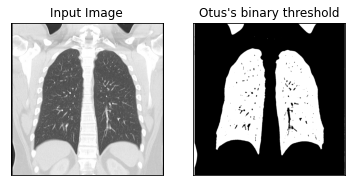

In [23]:
#************
#Can read .jpg, .jpe, .jpeg, .png formats
#In my case I tries images of Coronal lung window.zip in our repo
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('./Coronal lung window/8.jpg')
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.subplot(121),plt.imshow(rgb_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(thresh, 'gray')
plt.title("Otus's binary threshold"), plt.xticks([]), plt.yticks([])
plt.show()      

<h3>Using ConnectedThreshold</h3>

In [28]:
img = sitk.ReadImage("./2.000000-ROUTINE CHEST NON-CON-50599.nii")

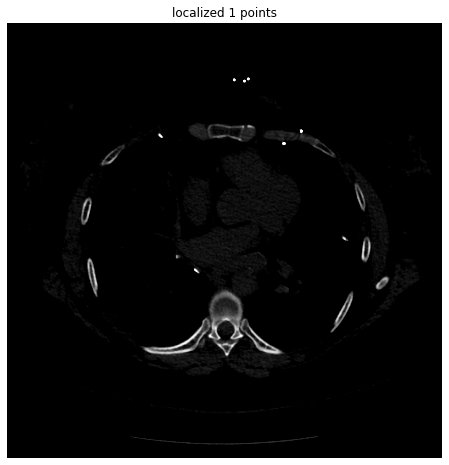

In [29]:
point_acquisition_interface = gui.PointDataAquisition(img, window_level=(1050,500))

#preselected seed point in the lung 
point_acquisition_interface.set_point_indexes([(132,142,96)])
initial_seed_point_indexes = point_acquisition_interface.get_point_indexes()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


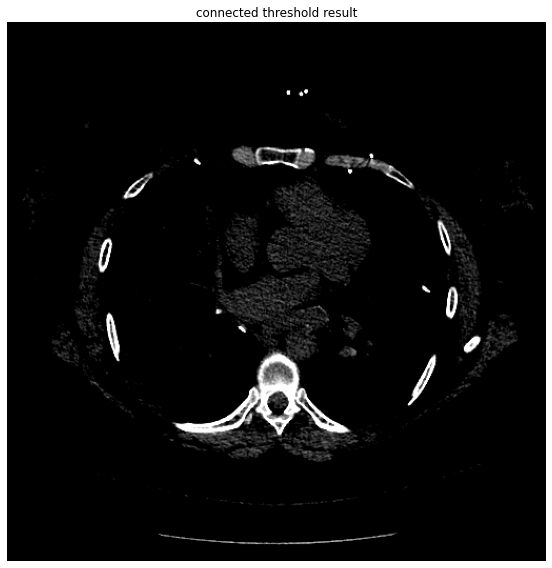

In [33]:
# seg = sitk.ConnectedThreshold(image, seedList=[initial_seed_point_indexes], lower=100, upper=190)
# myshow(sitk.LabelOverlay(imgage_rgb, seg), "Connected Threshold")
seg_explicit_thresholds = sitk.ConnectedThreshold(img, seedList=initial_seed_point_indexes, lower=100, upper=170)
# Overlay the segmentation onto the T1 image
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(img, seg_explicit_thresholds)],                   
                      title_list = ['connected threshold result'])

In [36]:
seg = sitk.ConfidenceConnected(image, seedList=initial_seed_point_indexes,
                                   numberOfIterations=1,
                                   multiplier=2.5,
                                   initialNeighborhoodRadius=1,
                                   replaceValue=1)

myshow(sitk.LabelOverlay(image_rgb, seg), "ConfidenceConnected")

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

<h3>Using Level-Set</h3>

In [37]:
stats = sitk.LabelStatisticsImageFilter()
stats.Execute(image, seg)

factor = 3.5
lower_threshold = stats.GetMean(1)-factor*stats.GetSigma(1)
upper_threshold = stats.GetMean(1)+factor*stats.GetSigma(1)
print(lower_threshold,upper_threshold)

-183.13500725451598 -35.504148480474015


In [38]:
init_ls = sitk.SignedMaurerDistanceMap(seg, insideIsPositive=True, useImageSpacing=True)

In [39]:
lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter()
lsFilter.SetLowerThreshold(lower_threshold)
lsFilter.SetUpperThreshold(upper_threshold)
lsFilter.SetMaximumRMSError(0.02)
lsFilter.SetNumberOfIterations(1000)
lsFilter.SetCurvatureScaling(.5)
lsFilter.SetPropagationScaling(1)
lsFilter.ReverseExpansionDirectionOn()
ls = lsFilter.Execute(init_ls, sitk.Cast(image, sitk.sitkFloat32))
print(lsFilter)

itk::simple::ThresholdSegmentationLevelSetImageFilter
  LowerThreshold: -183.135
  UpperThreshold: -35.5041
  MaximumRMSError: 0.02
  PropagationScaling: 1
  CurvatureScaling: 0.5
  NumberOfIterations: 1000
  ReverseExpansionDirection: 1
  ElapsedIterations: 2
  RMSChange: 0.00833263
  Debug: 0
  NumberOfThreads: 10
  NumberOfWorkUnits: 0
  Commands: (none)
  ProgressMeasurement: 0.002
  ActiveProcess: (none)



In [40]:
myshow(sitk.LabelOverlay(image_rgb, ls>0))

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

### Watershed Segmentation

In [42]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

import SimpleITK as sitk

# Download data to work on
%run update_path_to_download_script
# from downloaddata import fetch_data as fdata
from myshow import myshow, myshow3d
  
# Read the image
dicom_dir = "../NBIA_images/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/2.000000-ROUTINE CHEST NON-CON-97100"

print("Reading Dicom directory:", dicom_dir)
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)

reader.SetFileNames(dicom_names)
image = reader.Execute()

seg = image > 200
myshow(sitk.LabelOverlay(image, seg), "Watershed Segmentation")




Reading Dicom directory: ../NBIA_images/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/2.000000-ROUTINE CHEST NON-CON-97100


interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

### Gradient Watershed Segmentation

In [44]:
sigma = seg.GetSpacing()[0]
level = 4

In [45]:
feature_seg = sitk.GradientMagnitude(seg)
myshow(seg, "Edge Features")

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

In [46]:
seg = sitk.MorphologicalWatershed(
    feature_seg, level=0, markWatershedLine=True, fullyConnected=False
)
myshow(sitk.LabelToRGB(seg), "Watershed Over Segmentation")

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

In [47]:
from ipywidgets import interact, interactive, FloatSlider


def callback(feature_seg, *args, **kwargs):
    watershed_seg = sitk.MorphologicalWatershed(feature_seg, *args, **kwargs)

    myshow(sitk.LabelToRGB(watershed_seg), "Watershed Segmentation")


interact(
    lambda **kwargs: callback(feature_seg, **kwargs),
    markWatershedLine=True,
    fullyConnected=False,
    level=FloatSlider(min=0, max=255, step=0.1, value=4.0),
)

interactive(children=(Checkbox(value=True, description='markWatershedLine'), Checkbox(value=False, description…

<function __main__.<lambda>(**kwargs)>

### Segmentation From Markers

In [48]:
min_seg = sitk.RegionalMinima(
    seg,
    backgroundValue=0,
    foregroundValue=1.0,
    fullyConnected=False,
    flatIsMinima=True,
)
marker_seg = sitk.ConnectedComponent(min_seg)
myshow(sitk.LabelToRGB(marker_seg), "Too many local minima markers")

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

In [49]:
watershed = sitk.MorphologicalWatershedFromMarkers(
    feature_seg, marker_seg, markWatershedLine=True, fullyConnected=False
)
myshow(sitk.LabelToRGB(watershed), "Watershed Oversegmentation from markers")

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

### Binary Watersheds for Object Separation

In [59]:
# Read the image
dicom_dir = "../NBIA_images/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/2.000000-ROUTINE CHEST NON-CON-97100"

print("Reading Dicom directory:", dicom_dir)
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)

reader.SetFileNames(dicom_names)
image = reader.Execute()

seg = image > 200

Reading Dicom directory: ../NBIA_images/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/2.000000-ROUTINE CHEST NON-CON-97100


In [61]:
# rgb_seg = sitk.ReadImage(seg)
# myshow(rgb_seg, seg)
# img = sitk.VectorIndexSelectionCast(rgb_seg, 1)
# myshow(seg, seg)

In [62]:
feature_seg = sitk.GradientMagnitudeRecursiveGaussian(seg, sigma=1.5)
myshow(feature_seg)

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

In [63]:
watershed_seg = sitk.MorphologicalWatershed(
    feature_seg, level=4, markWatershedLine=False, fullyConnected=False
)
myshow(sitk.LabelToRGB(watershed_seg), "Watershed Over Segmentation")
segmentated = sitk.ConnectedComponent(watershed_seg != watershed_seg[0, 0])
myshow(sitk.LabelOverlay(seg, segmentated), "Foreground Components")

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

IndexError: invalid slice extraction to 1 dimension

In [64]:
filled = sitk.BinaryFillhole(seg != 0)
distance = sitk.SignedMaurerDistanceMap(
    filled, insideIsPositive=False, squaredDistance=False, useImageSpacing=False
)
myshow(distance, "Inside Distance Map")

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

In [65]:
watershed = sitk.MorphologicalWatershed(distance, markWatershedLine=False, level=1)
myshow(sitk.LabelOverlay(seg, watershed))

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

In [66]:
watershed = sitk.Mask(watershed, sitk.Cast(seg, watershed.GetPixelID()))
myshow(sitk.LabelOverlay(seg, watershed), "Split Objects")

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

### Multi-label Morphology

In [67]:
seg = watershed

In [68]:
radius = 10
binary_dilation_seg = sitk.BinaryDilate(seg != 0, [radius] * seg.GetDimension())
myshow(binary_dilation_seg, "Binary Dilate")

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

In [69]:
distance_seg = sitk.SignedMaurerDistanceMap(
    seg != 0, insideIsPositive=False, squaredDistance=False, useImageSpacing=False
)
watershed_distance_img = sitk.MorphologicalWatershedFromMarkers(distance_seg, seg, markWatershedLine=False)
myshow(sitk.LabelOverlay(seg, watershed_distance_img))

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

In [70]:
multi_label_dilate_seg = sitk.Mask(watershed_distance_img, binary_dilation_seg)
myshow(sitk.LabelToRGB(multi_label_dilate_seg), "Multi-label Dilate")

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

In [71]:
e_seg = sitk.BinaryErode(multi_label_dilate_seg != 0, [radius] * multi_label_dilate_seg.GetDimension())
multi_label_closing_seg = sitk.Mask(multi_label_dilate_seg, e_seg)
myshow(sitk.LabelOverlay(seg, multi_label_closing_seg), "Multi-label Closing")

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…


<h3>Quantification</h3>

In [4]:
# coronal scan of same patient's covid-infected lung showing disease markers

# TO-DO: manually setting path here, need an interface to take input
dicom_dir = "../NBIA_images/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/601.000000-COR 3X3-86740"

print("Reading Dicom directory:", dicom_dir)
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)

reader.SetFileNames(dicom_names)

image = reader.Execute()

size = image.GetSize()
print("Image size:", size[0], size[1], size[2])

print("Writing image:", "MIDRC-RICORD-1A_coronal_image.nii")

sitk.WriteImage(image, "MIDRC-RICORD-1A_coronal_image.nii")

if ("SITK_NOSHOW" not in os.environ):
    sitk.Show(image, "Dicom Series")
    
    
covid_example = sitk.ReadImage("./MIDRC-RICORD-1A_coronal_image.nii")

print("Dimensions: " + str(covid_example.GetDimension()))
print("Width: " + str(covid_example.GetWidth()))
print("Height: " + str(covid_example.GetHeight()))
print("Depth: " + str(covid_example.GetDepth()))
print("Pixel ID: " + str(covid_example.GetPixelIDValue()))
print("Pixel Type: " + str(covid_example.GetPixelIDTypeAsString()))
print("Components Per Pixel: " + str(covid_example.GetNumberOfComponentsPerPixel()))

Reading Dicom directory: ../NBIA_images/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/601.000000-COR 3X3-86740


ImageSeriesReader (0x7fe066f081e0): Non uniform sampling or missing slices detected,  maximum nonuniformity:176.653



Image size: 512 512 106
Writing image: MIDRC-RICORD-1A_coronal_image.nii
Dimensions: 3
Width: 512
Height: 512
Depth: 106
Pixel ID: 4
Pixel Type: 32-bit signed integer
Components Per Pixel: 1


In [5]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

import SimpleITK as sitk

# Download data to work on
%run update_path_to_download_script
# from downloaddata import fetch_data as fdata
from myshow import myshow, myshow3d
  
# Read the image
dicom_dir = "../NBIA_images/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/2.000000-ROUTINE CHEST NON-CON-97100"

print("Reading Dicom directory:", dicom_dir)
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)

reader.SetFileNames(dicom_names)
image = reader.Execute()

seg = image > 200
myshow(sitk.LabelOverlay(image, seg), "Basic Thresholding")


# To visualize the labels image in RGB with needs a image with 0-255 range
image_rgb = sitk.Cast(sitk.RescaleIntensity(image), sitk.sitkUInt8)

Reading Dicom directory: ../NBIA_images/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/2.000000-ROUTINE CHEST NON-CON-97100


interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

In [6]:
otsu_filter = sitk.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(0)
otsu_filter.SetOutsideValue(1)
seg = otsu_filter.Execute(image_rgb)
myshow(sitk.LabelOverlay(image_rgb, seg), "Otsu Thresholding")

print(otsu_filter.GetThreshold() )

interactive(children=(IntSlider(value=127, description='z', max=254), Output()), _dom_classes=('widget-interac…

1.0


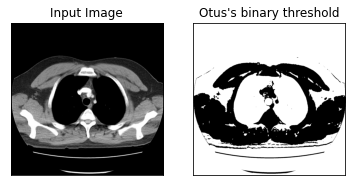

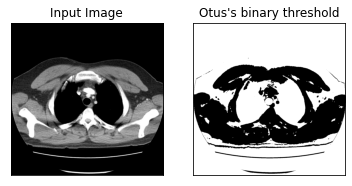

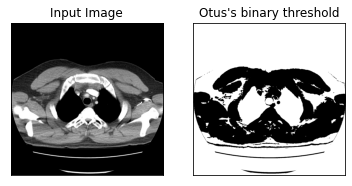

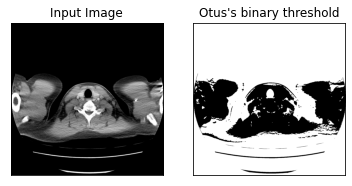

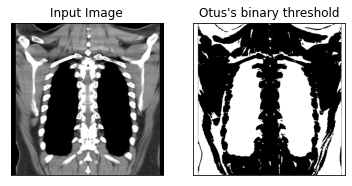

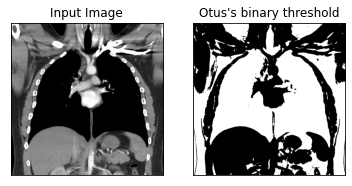

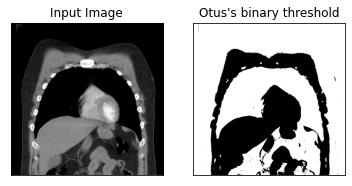

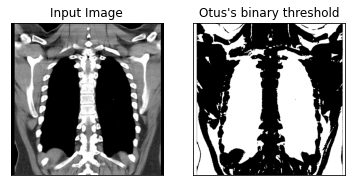

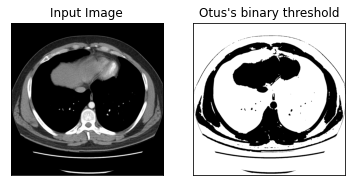

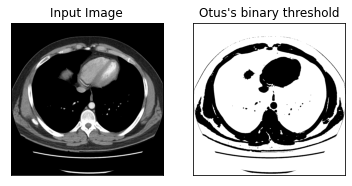

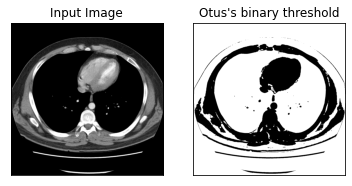

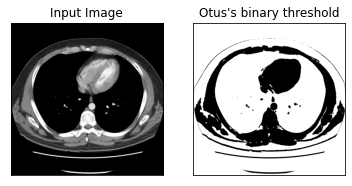

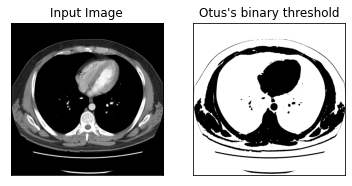

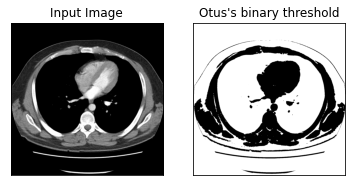

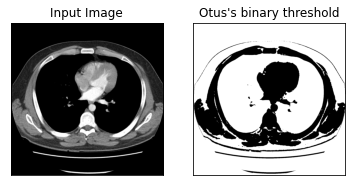

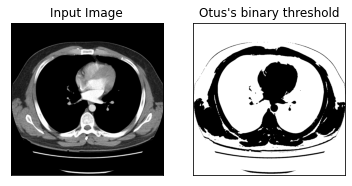

In [7]:
# Using an external viewer (ITK-SNAP or 3D Slicer) we identified a visually appealing window-level setting
T1_WINDOW_LEVEL = (1050, 500)

# image = sitk.ReadImage("NBIA_images/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/2.000000-ROUTINE CHEST NON-CON-97100")
# Rescale the intensities and map them to [0,255], these are the default values for the output
# We will use this image to display the results of segmentation
img_T1_255 = sitk.Cast(
    sitk.IntensityWindowing(
        image,
        windowMinimum=T1_WINDOW_LEVEL[1] - T1_WINDOW_LEVEL[0] / 2.0,
        windowMaximum=T1_WINDOW_LEVEL[1] + T1_WINDOW_LEVEL[0] / 2.0,
    ),
    sitk.sitkUInt8,
)

#************
#Can read .jpg, .jpe, .jpeg, .png formats
#In my case I tries images of Coronal lung window.zip in our repo
import numpy as np
import cv2
from matplotlib import pyplot as plt



for x in range(16):
    x += 1
    img = cv2.imread("./comparison/clean/axialc+_clean (" + str(x) + ").jpg")
    b,g,r = cv2.split(img)
    rgb_img = cv2.merge([r,g,b])

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    plt.subplot(121),plt.imshow(rgb_img)
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(thresh, 'gray')
    plt.title("Otus's binary threshold"), plt.xticks([]), plt.yticks([])
    plt.show()

    cv2.imwrite("./comparison/clean/threshold/" + str(x) + ".tif", thresh)



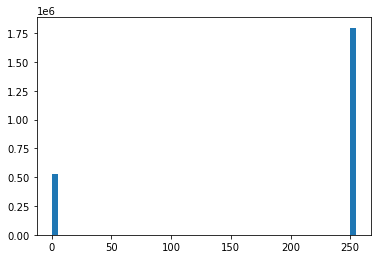

In [8]:
threshImg = sitk.ReadImage("./comparison/clean/threshold/10.tif")

plt.figure()
plt.hist(sitk.GetArrayViewFromImage(threshImg).flatten(), bins=50)
plt.show()

In [ ]:
!pip install diplib
import diplib as dip

for x in range (16):
    x +=1
    thresh = dip.ImageRead("./comparison/clean/threshold/" + str(x) + ".tif")
    thresh.SetPixelSize(dip.PixelSize(dip.PhysicalQuantity(1,"px")))

    thresh = dip.ColorSpaceManager.Convert(thresh, 'gray')
    #a.Show()


    obj = ~dip.Threshold(dip.Gauss(thresh))[0]
    obj = dip.EdgeObjectsRemove(obj)
    #obj.Show()


    obj = dip.Opening(dip.Closing(thresh,9),9)
    #obj.Show()
    
    newThresh = obj < 120
    newThresh = dip.EdgeObjectsRemove(newThresh)
    newThresh = dip.Label(newThresh, minSize=30)
    m = dip.MeasurementTool.Measure(newThresh, obj, ['Size', 'Solidity'])

    c = dip.ObjectToMeasurement(newThresh, m['Solidity'])
    c.Show(colormap='viridis')

    print(m)

<pre>
|       Size |   Solidity | ConvexArea | 
-- | ---------- | ---------- | ---------- | 
   |            |            |            | 
   |     (px^2) |            |     (px^2) | 
-- | ---------- | ---------- | ---------- | 
 1 |      512.0 |     0.8605 |      595.0 | 
 2 |  1.403e+04 |     0.8395 |  1.671e+04 | 
 3 |      619.0 |     0.9246 |      669.5 | 
 4 |      451.0 |     0.9505 |      474.5 | 
 5 |      174.0 |     0.9803 |      177.5 | 
 6 |      1197. |     0.9752 |      1228. | 
 7 |      135.0 |      1.000 |      135.0 | 
 8 |      69.00 |      1.000 |      69.00 | 
 9 |      111.0 |     0.9823 |      113.0 | 
10 |      222.0 |     0.9933 |      223.5 | 
11 |      2831. |     0.7055 |      4012. | 
12 |      3974. |     0.6336 |      6272. | 
13 |      129.0 |     0.9923 |      130.0 | 
14 |      69.00 |      1.000 |      69.00 | 
15 |      419.0 |     0.9001 |      465.5 | 
16 |      303.0 |     0.8925 |      339.5 | 
17 |      69.00 |      1.000 |      69.00 | 
18 |      146.0 |     0.9799 |      149.0 | 
19 |      87.00 |      1.000 |      87.00 | 
20 |      142.0 |     0.9895 |      143.5 | 
21 |      8301. |     0.2290 |  3.626e+04 | 
22 |      69.00 |      1.000 |      69.00 | 
23 |      151.0 |     0.9042 |      167.0 | 
24 |      6030. |     0.5783 |  1.043e+04 | 


   |       Size |   Solidity | ConvexArea | 
-- | ---------- | ---------- | ---------- | 
   |            |            |            | 
   |     (px^2) |            |     (px^2) | 
-- | ---------- | ---------- | ---------- | 
 1 |  1.559e+04 |     0.7321 |  2.129e+04 | 
 2 |      224.0 |     0.9218 |      243.0 | 
 3 |      103.0 |     0.9856 |      104.5 | 
 4 |      252.0 |     0.9825 |      256.5 | 
 5 |      195.0 |     0.9898 |      197.0 | 
 6 |      320.0 |     0.8877 |      360.5 | 
 7 |      175.0 |     0.7778 |      225.0 | 
 8 |      229.0 |     0.9807 |      233.5 | 
 9 |      231.0 |     0.9665 |      239.0 | 
10 |      974.0 |     0.9828 |      991.0 | 
11 |      3749. |     0.6554 |      5720. | 
12 |      8923. |     0.4293 |  2.078e+04 | 
13 |      527.0 |     0.8514 |      619.0 | 
14 |      274.0 |     0.9580 |      286.0 | 
15 |      8651. |     0.2262 |  3.824e+04 | 
16 |      78.00 |      1.000 |      78.00 | 
17 |      351.0 |     0.7888 |      445.0 | 
18 |      6129. |     0.5704 |  1.075e+04 | 


   |       Size |   Solidity | ConvexArea | 
-- | ---------- | ---------- | ---------- | 
   |            |            |            | 
   |     (px^2) |            |     (px^2) | 
-- | ---------- | ---------- | ---------- | 
 1 |      1105. |     0.5651 |      1956. | 
 2 |      1763. |     0.7602 |      2319. | 
 3 |      917.0 |     0.9855 |      930.5 | 
 4 |      169.0 |     0.9685 |      174.5 | 
 5 |      79.00 |     0.9693 |      81.50 | 
 6 |      379.0 |     0.8441 |      449.0 | 
 7 |  1.493e+04 |     0.2829 |  5.278e+04 | 
 8 |      333.0 |     0.8916 |      373.5 | 
 9 |      9975. |     0.1946 |  5.125e+04 | 
10 |      6286. |     0.5679 |  1.107e+04 | 


   |       Size |   Solidity | ConvexArea | 
-- | ---------- | ---------- | ---------- | 
   |            |            |            | 
   |     (px^2) |            |     (px^2) | 
-- | ---------- | ---------- | ---------- | 
 1 |  1.420e+05 |     0.8548 |  1.662e+05 | 
 2 |      3261. |     0.7627 |      4276. | 
 3 |      85.00 |      1.000 |      85.00 | 
 4 |      213.0 |     0.9816 |      217.0 | 
 5 |      159.0 |     0.9755 |      163.0 | 
 6 |      74.00 |     0.8605 |      86.00 | 
 7 |      69.00 |      1.000 |      69.00 | 
 8 |      990.0 |     0.9640 |      1027. | 
 9 |      280.0 |     0.9722 |      288.0 | 
10 |      369.0 |     0.8978 |      411.0 | 
11 |      179.0 |     0.9890 |      181.0 | 
12 |      114.0 |     0.9744 |      117.0 | 
13 |      5303. |     0.6372 |      8322. | 
14 |      177.0 |     0.9752 |      181.5 | 
15 |      444.0 |     0.9457 |      469.5 | 
16 |      516.0 |     0.8501 |      607.0 | 
17 |      69.00 |      1.000 |      69.00 | 
18 |      103.0 |     0.9904 |      104.0 | 
19 |      385.0 |     0.9178 |      419.5 | 
20 |      156.0 |     0.9842 |      158.5 | 
21 |  1.021e+04 |     0.2220 |  4.597e+04 | 
22 |      6762. |     0.5676 |  1.191e+04 | 


   |       Size |   Solidity | ConvexArea | 
-- | ---------- | ---------- | ---------- | 
   |            |            |            | 
   |     (px^2) |            |     (px^2) | 
-- | ---------- | ---------- | ---------- | 
 1 |      183.0 |     0.9786 |      187.0 | 
 2 |      739.0 |     0.8470 |      872.5 | 
 3 |      242.0 |     0.9490 |      255.0 | 
 4 |      203.0 |     0.9312 |      218.0 | 
 5 |      1594. |     0.6747 |      2362. | 
 6 |      130.0 |     0.9630 |      135.0 | 
 7 |      87.00 |      1.000 |      87.00 | 
 8 |      91.00 |     0.9529 |      95.50 | 
 9 |      164.0 |     0.9820 |      167.0 | 
10 |      78.00 |      1.000 |      78.00 | 
11 |      192.0 |     0.9648 |      199.0 | 
12 |      343.0 |     0.9541 |      359.5 | 
13 |      184.0 |     0.9813 |      187.5 | 
14 |      2006. |     0.8416 |      2384. | 
15 |      193.0 |     0.9772 |      197.5 | 
16 |      160.0 |     0.8247 |      194.0 | 
17 |      78.00 |      1.000 |      78.00 | 
18 |      78.00 |      1.000 |      78.00 | 


   |       Size |   Solidity | ConvexArea | 
-- | ---------- | ---------- | ---------- | 
   |            |            |            | 
   |     (px^2) |            |     (px^2) | 
-- | ---------- | ---------- | ---------- | 
 1 |      69.00 |      1.000 |      69.00 | 
 2 |      272.0 |     0.9837 |      276.5 | 
 3 |      7341. |     0.5624 |  1.305e+04 | 
 4 |      168.0 |     0.9739 |      172.5 | 
 5 |      1003. |     0.8082 |      1241. | 
 6 |      635.0 |     0.8912 |      712.5 | 
 7 |      170.0 |     0.9884 |      172.0 | 
 8 |      85.00 |      1.000 |      85.00 | 
 9 |      1677. |     0.7701 |      2178. | 
10 |      1192. |     0.9106 |      1309. | 
11 |      78.00 |      1.000 |      78.00 | 


  |       Size |   Solidity | ConvexArea | 
- | ---------- | ---------- | ---------- | 
  |            |            |            | 
  |     (px^2) |            |     (px^2) | 
- | ---------- | ---------- | ---------- | 
1 |      88.00 |     0.9944 |      88.50 | 
2 |      3302. |     0.9444 |      3496. | 
3 |      84.00 |     0.9545 |      88.00 | 
4 |      465.0 |     0.9442 |      492.5 | 
5 |      282.0 |     0.8812 |      320.0 | 
6 |      855.0 |     0.7823 |      1093. | 
7 |      79.00 |     0.9693 |      81.50 | 


  |       Size |   Solidity | ConvexArea | 
- | ---------- | ---------- | ---------- | 
  |            |            |            | 
  |     (px^2) |            |     (px^2) | 
- | ---------- | ---------- | ---------- | 
1 |      968.0 |     0.7951 |      1218. | 
2 |      227.0 |     0.9806 |      231.5 | 
3 |      348.0 |     0.8266 |      421.0 | 
4 |      69.00 |      1.000 |      69.00 | 
5 |      98.00 |     0.9655 |      101.5 | 
6 |      180.0 |      1.000 |      180.0 | 
7 |      1547. |     0.9219 |      1678. | 
8 |      78.00 |      1.000 |      78.00 | 
9 |      257.0 |     0.9590 |      268.0 | 


   |       Size |   Solidity | ConvexArea | 
-- | ---------- | ---------- | ---------- | 
   |            |            |            | 
   |     (px^2) |            |     (px^2) | 
-- | ---------- | ---------- | ---------- | 
 1 |  3.792e+05 |     0.3244 |  1.169e+06 | 
 2 |      149.0 |     0.9739 |      153.0 | 
 3 |      284.0 |     0.8161 |      348.0 | 
 4 |  1.509e+05 |     0.8621 |  1.750e+05 | 
 5 |      855.0 |     0.9396 |      910.0 | 
 6 |      99.00 |      1.000 |      99.00 | 
 7 |      103.0 |      1.000 |      103.0 | 
 8 |      100.0 |      1.000 |      100.0 | 
 9 |      274.0 |     0.9874 |      277.5 | 
10 |      101.0 |     0.9951 |      101.5 | 
11 |      310.0 |     0.9904 |      313.0 | 
12 |      78.00 |      1.000 |      78.00 | 
13 |      257.0 |     0.9790 |      262.5 | 
14 |  2.155e+04 |     0.1236 |  1.744e+05 | 
15 |  1.305e+04 |     0.2363 |  5.521e+04 | 
16 |      6226. |     0.5812 |  1.071e+04 | 


   |       Size |   Solidity | ConvexArea | 
-- | ---------- | ---------- | ---------- | 
   |            |            |            | 
   |     (px^2) |            |     (px^2) | 
-- | ---------- | ---------- | ---------- | 
 1 |  3.721e+05 |     0.3198 |  1.164e+06 | 
 2 |  9.979e+04 |     0.9176 |  1.088e+05 | 
 3 |      6317. |     0.9274 |      6812. | 
 4 |      1418. |     0.9571 |      1482. | 
 5 |      121.0 |     0.9918 |      122.0 | 
 6 |      486.0 |     0.9643 |      504.0 | 
 7 |      107.0 |      1.000 |      107.0 | 
 8 |      138.0 |     0.9753 |      141.5 | 
 9 |      78.00 |      1.000 |      78.00 | 
10 |      217.0 |     0.9819 |      221.0 | 
11 |      251.0 |     0.9843 |      255.0 | 
12 |      116.0 |      1.000 |      116.0 | 
13 |      208.0 |     0.9928 |      209.5 | 
14 |  2.048e+04 |     0.1211 |  1.692e+05 | 
15 |  1.294e+04 |     0.2352 |  5.500e+04 | 
16 |      6220. |     0.5831 |  1.067e+04 | 


   |       Size |   Solidity | ConvexArea | 
-- | ---------- | ---------- | ---------- | 
   |            |            |            | 
   |     (px^2) |            |     (px^2) | 
-- | ---------- | ---------- | ---------- | 
 1 |  3.761e+05 |     0.3233 |  1.163e+06 | 
 2 |  1.096e+05 |     0.9372 |  1.170e+05 | 
 3 |      1468. |     0.9633 |      1524. | 
 4 |      456.0 |     0.9870 |      462.0 | 
 5 |      117.0 |     0.9957 |      117.5 | 
 6 |      232.0 |     0.9915 |      234.0 | 
 7 |      214.0 |     0.9862 |      217.0 | 
 8 |      225.0 |     0.9847 |      228.5 | 
 9 |      123.0 |     0.9880 |      124.5 | 
10 |      250.0 |     0.9881 |      253.0 | 
11 |  2.035e+04 |     0.1199 |  1.698e+05 | 
12 |  1.288e+04 |     0.2324 |  5.543e+04 | 
13 |      6219. |     0.5855 |  1.062e+04 | 


   |       Size |   Solidity | ConvexArea | 
-- | ---------- | ---------- | ---------- | 
   |            |            |            | 
   |     (px^2) |            |     (px^2) | 
-- | ---------- | ---------- | ---------- | 
 1 |  3.894e+05 |     0.3341 |  1.165e+06 | 
 2 |  1.128e+05 |     0.9462 |  1.192e+05 | 
 3 |      459.0 |     0.9882 |      464.5 | 
 4 |      547.0 |     0.9571 |      571.5 | 
 5 |      598.0 |     0.7209 |      829.5 | 
 6 |      179.0 |      1.000 |      179.0 | 
 7 |      504.0 |     0.9777 |      515.5 | 
 8 |      102.0 |      1.000 |      102.0 | 
 9 |      325.0 |     0.9863 |      329.5 | 
10 |      92.00 |      1.000 |      92.00 | 
11 |  1.945e+04 |     0.1129 |  1.723e+05 | 
12 |  1.256e+04 |     0.2307 |  5.446e+04 | 
13 |      6082. |     0.5782 |  1.052e+04 | 


   |       Size |   Solidity | ConvexArea | 
-- | ---------- | ---------- | ---------- | 
   |            |            |            | 
   |     (px^2) |            |     (px^2) | 
-- | ---------- | ---------- | ---------- | 
 1 |  3.965e+05 |     0.3405 |  1.164e+06 | 
 2 |  1.197e+05 |     0.9328 |  1.283e+05 | 
 3 |      513.0 |     0.9790 |      524.0 | 
 4 |      607.0 |     0.9100 |      667.0 | 
 5 |      725.0 |     0.9699 |      747.5 | 
 6 |      4233. |     0.9845 |      4300. | 
 7 |      590.0 |     0.9768 |      604.0 | 
 8 |      217.0 |     0.9709 |      223.5 | 
 9 |      285.0 |     0.9744 |      292.5 | 
10 |      249.0 |     0.9940 |      250.5 | 
11 |      316.0 |     0.9798 |      322.5 | 
12 |  1.855e+04 |     0.1098 |  1.689e+05 | 
13 |  1.237e+04 |     0.2270 |  5.450e+04 | 
14 |      5989. |     0.5653 |  1.060e+04 | 


   |       Size |   Solidity | ConvexArea | 
-- | ---------- | ---------- | ---------- | 
   |            |            |            | 
   |     (px^2) |            |     (px^2) | 
-- | ---------- | ---------- | ---------- | 
 1 |  5.323e+05 |     0.4554 |  1.169e+06 | 
 2 |      223.0 |     0.9889 |      225.5 | 
 3 |      95.00 |      1.000 |      95.00 | 
 4 |      2631. |     0.9302 |      2828. | 
 5 |      353.0 |     0.9847 |      358.5 | 
 6 |      655.0 |     0.9740 |      672.5 | 
 7 |      377.0 |     0.9805 |      384.5 | 
 8 |  1.812e+04 |     0.1127 |  1.608e+05 | 
 9 |  1.234e+04 |     0.2274 |  5.428e+04 | 
10 |      6042. |     0.5735 |  1.054e+04 | 


   |       Size |   Solidity | ConvexArea | 
-- | ---------- | ---------- | ---------- | 
   |            |            |            | 
   |     (px^2) |            |     (px^2) | 
-- | ---------- | ---------- | ---------- | 
 1 |  5.490e+05 |     0.4654 |  1.180e+06 | 
 2 |      264.0 |     0.9688 |      272.5 | 
 3 |      1016. |     0.8839 |      1150. | 
 4 |      114.0 |     0.9785 |      116.5 | 
 5 |      651.0 |     0.9659 |      674.0 | 
 6 |      604.0 |     0.9549 |      632.5 | 
 7 |      91.00 |     0.9945 |      91.50 | 
 8 |  1.806e+04 |     0.1150 |  1.570e+05 | 
 9 |  1.244e+04 |     0.2297 |  5.416e+04 | 
10 |      6054. |     0.5797 |  1.044e+04 | 


   |       Size |   Solidity | ConvexArea | 
-- | ---------- | ---------- | ---------- | 
   |            |            |            | 
   |     (px^2) |            |     (px^2) | 
-- | ---------- | ---------- | ---------- | 
 1 |  5.581e+05 |     0.4738 |  1.178e+06 | 
 2 |      69.00 |      1.000 |      69.00 | 
 3 |      275.0 |     0.9683 |      284.0 | 
 4 |      328.0 |     0.9791 |      335.0 | 
 5 |      922.0 |     0.9710 |      949.5 | 
 6 |      993.0 |     0.9430 |      1053. | 
 7 |      637.0 |     0.9696 |      657.0 | 
 8 |      415.0 |     0.8868 |      468.0 | 
 9 |  1.670e+04 |     0.1344 |  1.243e+05 | 
10 |  1.202e+04 |     0.2177 |  5.519e+04 | 
11 |      6164. |     0.5817 |  1.060e+04 | 
</pre>
